In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 8
core id		: 0
cpu cores	: 4
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
addres

In [ ]:
!cat /proc/meminfo

MemTotal:       53474512 kB
MemFree:        49879332 kB
MemAvailable:   51878188 kB
Buffers:           92960 kB
Cached:          2375384 kB
SwapCached:            0 kB
Active:           564924 kB
Inactive:        2657496 kB
Active(anon):        964 kB
Inactive(anon):   754432 kB
Active(file):     563960 kB
Inactive(file):  1903064 kB
Unevictable:           4 kB
Mlocked:               4 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              3872 kB
Writeback:             0 kB
AnonPages:        754248 kB
Mapped:           265660 kB
Shmem:              1288 kB
KReclaimable:      79096 kB
Slab:             130600 kB
SReclaimable:      79096 kB
SUnreclaim:        51504 kB
KernelStack:        6256 kB
PageTables:        16168 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:    26737256 kB
Committed_AS:    2695936 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       74384 kB
VmallocChunk:          0 kB
Percpu:          

In [ ]:
!nvidia-smi

Sat Dec  9 19:49:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
# if use colab, run this part
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/539_notebook/ASL_539_Project')

Mounted at /content/drive


## Data Preprocessing Part

In [1]:
# imports
TESTING = False
TRAINING = True
import sys
print(sys.executable)
import pandas as pd
from PIL import Image
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch
import torchvision
import torch.optim as optim
import os
from tqdm import tqdm
from torchvision.ops import box_iou
import numpy as np
import matplotlib.pyplot as plt

c:\Users\tiany\anaconda3\python.exe


In [2]:
# check if cuda is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [3]:
# load in data

train_annotation = pd.read_csv('data/train/_annotations.csv')
val_annotation = pd.read_csv('data/valid/_annotations.csv')
test_annotation = pd.read_csv('data/test/_annotations.csv')

if TESTING: #reduce data size to increase testing speed
    train_annotation = train_annotation[:100]

# print the number of samples of the data
print("Number of training, validation and testing samples")
print(len(train_annotation))
print(len(val_annotation))
print(len(test_annotation))

# check the dimension of image is the same
print("min and max width and height of training images: ", train_annotation['width'].min(), train_annotation['width'].max(), train_annotation['height'].min(), train_annotation['height'].max())
print("min and max width and height of validation images: ", val_annotation['width'].min(), val_annotation['width'].max(), val_annotation['height'].min(), val_annotation['height'].max())
print("min and max width and height of testing images: ", test_annotation['width'].min(), test_annotation['width'].max(), test_annotation['height'].min(), test_annotation['height'].max())

Number of training, validation and testing samples
1512
144
72
min and max width and height of training images:  512 512 512 512
min and max width and height of validation images:  512 512 512 512
min and max width and height of testing images:  512 512 512 512


In [4]:
# function map the class name to an integer
def charToVal(c):
    return ord(c) - 64

def valToChar(v):
    return chr(v + 64)

## Dataset Class

In [5]:
# image dimension
img_width = 512
img_height = 512

In [6]:
# create the dataset class

class ASLDataset(Dataset):
    """
    Custom ASL dataset needed for training
    """
    def __init__(self, annotation, img_dir, transforms=None):
        # initialize the annotation, paths to images, and transforms
        self.annotation = annotation
        self.img_dir = img_dir
        self.transforms = transforms

    def __len__(self):
        # return the length of the dataset
        return len(self.annotation)

    def __getitem__(self, idx):
        filename = self.annotation.at[idx, 'filename']

        class_name = self.annotation.at[idx, 'class']
        xmin = self.annotation.at[idx, 'xmin']
        xmax = self.annotation.at[idx, 'xmax']
        ymin = self.annotation.at[idx, 'ymin']
        ymax = self.annotation.at[idx, 'ymax']

        # read in the image
        path = os.path.join(self.img_dir, filename)
        img = Image.open(path).convert("RGB")

        if self.transforms is not None:
            img = self.transforms(img)

        # target
        target = {}
        target['boxes'] = torch.as_tensor([[xmin, ymin, xmax, ymax]], dtype=torch.float32)
        target['labels'] = torch.as_tensor([charToVal(class_name)], dtype=torch.int64)

        return img, target

In [7]:
# define the transforms
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

# create the dataset
train_dataset = ASLDataset(train_annotation, 'data/train', data_transform)
val_dataset = ASLDataset(val_annotation, 'data/valid', data_transform)
test_dataset = ASLDataset(test_annotation, 'data/test', data_transform)

## Model Training Part

In [9]:
def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    intersection = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    areaA = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    areaB = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    return intersection / float(areaA + areaB - intersection)

In [10]:
def find_best_iou(pred_box, target_box):
    best_iou = 0
    best_index = -1
    for i, box in enumerate(pred_box):
        curr_iou = iou(box, target_box)
        if curr_iou > best_iou:
            best_iou = curr_iou
            best_index = i
    return best_iou, best_index

#test find best iou

target_box = np.array([32., 15., 263., 326.,])
pred_boxes = np.array([[37., 65., 395., 512.], [75.232, 161.32132, 401.234, 486.213]])

best_iou, best_idx = find_best_iou(pred_boxes, target_box)
print(best_iou, best_idx)

0.3423121640133071 0


In [11]:
# collate function
def collate_fn(batch):
    images, targets = zip(*batch)
    images = list(images)
    targets = list(targets)
    return images, targets

In [12]:
# initialize dataloaders
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [ ]:
# check for possible classes in the dataloader

classes = []
for images, targets in tqdm(train_dataloader):
    for target in targets:
        classes.append(target['labels'][0].item())
classes = set(classes)
print(classes)

In [ ]:
# check the dataloader
images, targets = next(iter(train_dataloader))
print(images)
print(targets)

[tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0

In [ ]:
# find the best learning rate
lr_list =[1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
loss_list = []

for lr in lr_list:
    # define the model
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    num_classes = 27
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    # define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # move the model to the device
    model.to(device)

    # train the model
    num_epochs = 5
    total_train_loss = 0.0
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, targets in tqdm(train_dataloader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss = train_loss / len(train_dataloader)
        print("Epoch: {} Loss: {}".format(epoch, train_loss))
        total_train_loss += train_loss
    loss_list.append(total_train_loss / num_epochs)

c:\Users\tiany\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\tiany\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/25 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
loss_list

[0.5308821289539336,
 0.3524891822338104,
 42.38216641914845,
 1.8355982069410655e+28,
 nan]

best learning rate: 0.0001

In [ ]:
# redefine the model
model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 27
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# training preparation
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 50 if TRAINING else 1
if not TRAINING:
    print("Not training, only testing")


H = {}
H['train_loss'] = []
H['val_ious'] = []
H['val_acc'] = []
H['loss_classifier'] = []
H['loss_box_reg'] = []
H['loss_objectness'] = []
H['loss_rpn_box_reg'] = []



Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 152MB/s]


In [ ]:
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    loss_classifier = 0.0
    loss_box_reg = 0.0
    loss_objectness = 0.0
    loss_rpn_box_reg = 0.0
    for images, targets in tqdm(train_dataloader):
        optimizer.zero_grad()
        images = list(image.to(device) for image in images)


        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        #print(len(images))
        #print(len(targets))
        loss_dict = model(images, targets)
        #print('targets: ', targets)
        #print(loss_dict)
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()

        train_loss += losses.item()
        loss_classifier += loss_dict['loss_classifier'].item()
        loss_box_reg += loss_dict['loss_box_reg'].item()
        loss_objectness += loss_dict['loss_objectness'].item()
        loss_rpn_box_reg += loss_dict['loss_rpn_box_reg'].item()
    print(f"Epoch {epoch + 1} Loss: {train_loss/len(train_dataloader)}")
    H["train_loss"].append(train_loss/len(train_dataloader))
    H["loss_classifier"].append(loss_classifier/len(train_dataloader))
    H["loss_box_reg"].append(loss_box_reg/len(train_dataloader))
    H["loss_objectness"].append(loss_objectness/len(train_dataloader))
    H["loss_rpn_box_reg"].append(loss_rpn_box_reg/len(train_dataloader))

    model.eval()
    mean_ious = 0.0
    mean_acc = 0.0

    with torch.no_grad():
        for images, targets in tqdm(val_dataloader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)
            #print(outputs)

            ious = []
            iou_idxs = []
            true_classes = []
            pred_classes = []

            for i, output in enumerate(outputs):
                target_box = targets[i]['boxes'][0].cpu().numpy()
                pred_boxes = output['boxes'].cpu().numpy()
                #print(pred_boxes)
                #print(target_box)
                best_iou, best_idx = find_best_iou(pred_boxes, target_box)
                ious.append(best_iou)
                iou_idxs.append(best_idx)

                true_class = targets[i]['labels'][0].cpu().numpy()
                if best_idx == -1:
                    pred_class = 0
                else:
                    pred_class = output['labels'][best_idx].cpu().numpy()
                true_classes.append(true_class)
                pred_classes.append(pred_class)

            mean_ious += sum(ious)/len(ious)
            mean_acc += sum([1 if true_classes[i] == pred_classes[i] else 0 for i in range(len(true_classes))])/len(true_classes)
    H['val_ious'].append(mean_ious/len(val_dataloader))
    H['val_acc'].append(mean_acc/len(val_dataloader))
    print(f"Epoch {epoch + 1} Mean IOU: {mean_ious/len(val_dataloader)}")
    print(f"Epoch {epoch + 1} Mean Accuracy: {mean_acc/len(val_dataloader)}")

100%|██████████| 189/189 [05:39<00:00,  1.79s/it]


Epoch 1 Loss: 0.3291436904479587


100%|██████████| 18/18 [00:33<00:00,  1.86s/it]


Epoch 1 Mean IOU: 0.882413529655769
Epoch 1 Mean Accuracy: 0.1388888888888889


100%|██████████| 189/189 [01:41<00:00,  1.86it/s]


Epoch 2 Loss: 0.17369695997269696


100%|██████████| 18/18 [00:04<00:00,  3.66it/s]


Epoch 2 Mean IOU: 0.8812934480649663
Epoch 2 Mean Accuracy: 0.1736111111111111


100%|██████████| 189/189 [01:40<00:00,  1.88it/s]


Epoch 3 Loss: 0.13003732835647291


100%|██████████| 18/18 [00:04<00:00,  3.64it/s]


Epoch 3 Mean IOU: 0.8856887718737477
Epoch 3 Mean Accuracy: 0.375


100%|██████████| 189/189 [01:41<00:00,  1.86it/s]


Epoch 4 Loss: 0.099049226040878


100%|██████████| 18/18 [00:05<00:00,  3.42it/s]


Epoch 4 Mean IOU: 0.8748167583606798
Epoch 4 Mean Accuracy: 0.4166666666666667


100%|██████████| 189/189 [01:40<00:00,  1.88it/s]


Epoch 5 Loss: 0.08524444107971495


100%|██████████| 18/18 [00:04<00:00,  3.67it/s]


Epoch 5 Mean IOU: 0.8929620811582029
Epoch 5 Mean Accuracy: 0.4722222222222222


100%|██████████| 189/189 [01:40<00:00,  1.87it/s]


Epoch 6 Loss: 0.06756644195349759


100%|██████████| 18/18 [00:05<00:00,  3.35it/s]


Epoch 6 Mean IOU: 0.8850974778535413
Epoch 6 Mean Accuracy: 0.4166666666666667


100%|██████████| 189/189 [01:40<00:00,  1.88it/s]


Epoch 7 Loss: 0.05743152632442101


100%|██████████| 18/18 [00:05<00:00,  3.10it/s]


Epoch 7 Mean IOU: 0.8889791250002629
Epoch 7 Mean Accuracy: 0.6041666666666666


100%|██████████| 189/189 [01:40<00:00,  1.89it/s]


Epoch 8 Loss: 0.05138659284070686


100%|██████████| 18/18 [00:05<00:00,  3.32it/s]


Epoch 8 Mean IOU: 0.8859973978938629
Epoch 8 Mean Accuracy: 0.5416666666666666


100%|██████████| 189/189 [01:41<00:00,  1.87it/s]


Epoch 9 Loss: 0.04748763451500544


100%|██████████| 18/18 [00:05<00:00,  3.15it/s]


Epoch 9 Mean IOU: 0.897076736297203
Epoch 9 Mean Accuracy: 0.5694444444444444


100%|██████████| 189/189 [01:40<00:00,  1.88it/s]


Epoch 10 Loss: 0.043007343968071


100%|██████████| 18/18 [00:05<00:00,  3.32it/s]


Epoch 10 Mean IOU: 0.8973747854490421
Epoch 10 Mean Accuracy: 0.5972222222222222


100%|██████████| 189/189 [01:41<00:00,  1.87it/s]


Epoch 11 Loss: 0.03997625639198949


100%|██████████| 18/18 [00:05<00:00,  3.16it/s]


Epoch 11 Mean IOU: 0.8707744238073464
Epoch 11 Mean Accuracy: 0.5555555555555556


100%|██████████| 189/189 [01:40<00:00,  1.89it/s]


Epoch 12 Loss: 0.038121340382430285


100%|██████████| 18/18 [00:05<00:00,  3.31it/s]


Epoch 12 Mean IOU: 0.9003908823475579
Epoch 12 Mean Accuracy: 0.5347222222222222


100%|██████████| 189/189 [01:40<00:00,  1.87it/s]


Epoch 13 Loss: 0.03476796463802063


100%|██████████| 18/18 [00:05<00:00,  3.12it/s]


Epoch 13 Mean IOU: 0.9072548064435346
Epoch 13 Mean Accuracy: 0.6944444444444444


100%|██████████| 189/189 [01:40<00:00,  1.88it/s]


Epoch 14 Loss: 0.03212955836502333


100%|██████████| 18/18 [00:05<00:00,  3.16it/s]


Epoch 14 Mean IOU: 0.9055722317195669
Epoch 14 Mean Accuracy: 0.6180555555555556


100%|██████████| 189/189 [01:40<00:00,  1.88it/s]


Epoch 15 Loss: 0.03201057276042996


100%|██████████| 18/18 [00:05<00:00,  3.22it/s]


Epoch 15 Mean IOU: 0.9054524201967966
Epoch 15 Mean Accuracy: 0.6319444444444444


100%|██████████| 189/189 [01:40<00:00,  1.89it/s]


Epoch 16 Loss: 0.030449818149603233


100%|██████████| 18/18 [00:05<00:00,  3.10it/s]


Epoch 16 Mean IOU: 0.904406327020864
Epoch 16 Mean Accuracy: 0.6597222222222222


100%|██████████| 189/189 [01:40<00:00,  1.88it/s]


Epoch 17 Loss: 0.028635437427847472


100%|██████████| 18/18 [00:05<00:00,  3.39it/s]


Epoch 17 Mean IOU: 0.9012484639486957
Epoch 17 Mean Accuracy: 0.6458333333333334


100%|██████████| 189/189 [01:40<00:00,  1.88it/s]


Epoch 18 Loss: 0.027828178314304855


100%|██████████| 18/18 [00:05<00:00,  3.05it/s]


Epoch 18 Mean IOU: 0.904903716862001
Epoch 18 Mean Accuracy: 0.6944444444444444


100%|██████████| 189/189 [01:40<00:00,  1.87it/s]


Epoch 19 Loss: 0.02745262308726235


100%|██████████| 18/18 [00:05<00:00,  3.49it/s]


Epoch 19 Mean IOU: 0.9074232950319914
Epoch 19 Mean Accuracy: 0.7152777777777778


100%|██████████| 189/189 [01:41<00:00,  1.86it/s]


Epoch 20 Loss: 0.02626459610958894


100%|██████████| 18/18 [00:05<00:00,  3.50it/s]


Epoch 20 Mean IOU: 0.9080195902340734
Epoch 20 Mean Accuracy: 0.7013888888888888


100%|██████████| 189/189 [01:40<00:00,  1.88it/s]


Epoch 21 Loss: 0.026984153423832837


100%|██████████| 18/18 [00:05<00:00,  3.35it/s]


Epoch 21 Mean IOU: 0.9034207290639598
Epoch 21 Mean Accuracy: 0.6944444444444444


100%|██████████| 189/189 [01:41<00:00,  1.86it/s]


Epoch 22 Loss: 0.025114339702422658


100%|██████████| 18/18 [00:05<00:00,  3.07it/s]


Epoch 22 Mean IOU: 0.9057376090154574
Epoch 22 Mean Accuracy: 0.6805555555555556


100%|██████████| 189/189 [01:40<00:00,  1.88it/s]


Epoch 23 Loss: 0.024217023036230807


100%|██████████| 18/18 [00:05<00:00,  3.24it/s]


Epoch 23 Mean IOU: 0.9042525037048951
Epoch 23 Mean Accuracy: 0.6875


100%|██████████| 189/189 [01:40<00:00,  1.87it/s]


Epoch 24 Loss: 0.02464905229924375


100%|██████████| 18/18 [00:05<00:00,  3.32it/s]


Epoch 24 Mean IOU: 0.9009001867414237
Epoch 24 Mean Accuracy: 0.6666666666666666


100%|██████████| 189/189 [01:40<00:00,  1.88it/s]


Epoch 25 Loss: 0.021627559932687924


100%|██████████| 18/18 [00:05<00:00,  3.53it/s]


Epoch 25 Mean IOU: 0.9068122281080577
Epoch 25 Mean Accuracy: 0.7013888888888888


100%|██████████| 189/189 [01:40<00:00,  1.88it/s]


Epoch 26 Loss: 0.02069099919584693


100%|██████████| 18/18 [00:05<00:00,  3.33it/s]


Epoch 26 Mean IOU: 0.902479788678879
Epoch 26 Mean Accuracy: 0.7430555555555556


100%|██████████| 189/189 [01:40<00:00,  1.88it/s]


Epoch 27 Loss: 0.021388537526406622


100%|██████████| 18/18 [00:05<00:00,  3.60it/s]


Epoch 27 Mean IOU: 0.9138892371413581
Epoch 27 Mean Accuracy: 0.7430555555555556


100%|██████████| 189/189 [01:40<00:00,  1.87it/s]


Epoch 28 Loss: 0.019888457994927805


100%|██████████| 18/18 [00:04<00:00,  3.68it/s]


Epoch 28 Mean IOU: 0.9050617030720259
Epoch 28 Mean Accuracy: 0.625


100%|██████████| 189/189 [01:40<00:00,  1.87it/s]


Epoch 29 Loss: 0.020146141582656475


100%|██████████| 18/18 [00:05<00:00,  3.60it/s]


Epoch 29 Mean IOU: 0.9066996443860885
Epoch 29 Mean Accuracy: 0.6458333333333334


100%|██████████| 189/189 [01:41<00:00,  1.86it/s]


Epoch 30 Loss: 0.019601306237438054


100%|██████████| 18/18 [00:05<00:00,  3.54it/s]


Epoch 30 Mean IOU: 0.9085979181346643
Epoch 30 Mean Accuracy: 0.6875


100%|██████████| 189/189 [01:40<00:00,  1.88it/s]


Epoch 31 Loss: 0.019008294496902084


100%|██████████| 18/18 [00:05<00:00,  3.59it/s]


Epoch 31 Mean IOU: 0.9118939605670432
Epoch 31 Mean Accuracy: 0.7222222222222222


100%|██████████| 189/189 [01:41<00:00,  1.86it/s]


Epoch 32 Loss: 0.034202918124498514


100%|██████████| 18/18 [00:04<00:00,  3.62it/s]


Epoch 32 Mean IOU: 0.8929464022251269
Epoch 32 Mean Accuracy: 0.5763888888888888


  0%|          | 0/189 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a94b54e5bd0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a94b54e5bd0>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    
if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
assert self._pare

Epoch 33 Loss: 0.021452203915311545


  0%|          | 0/18 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a94b54e5bd0><function _MultiProcessingDataLoaderIter.__del__ at 0x7a94b54e5bd0>
Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
if w.is_alive():    
if w.is_alive():  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3.1

Epoch 33 Mean IOU: 0.9051083213561522
Epoch 33 Mean Accuracy: 0.7152777777777778


  0%|          | 0/189 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a94b54e5bd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a94b54e5bd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

Epoch 34 Loss: 0.016871139436723696


  0%|          | 0/18 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a94b54e5bd0><function _MultiProcessingDataLoaderIter.__del__ at 0x7a94b54e5bd0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorif w.is_alive():: can only t

Epoch 34 Mean IOU: 0.9147350872261841
Epoch 34 Mean Accuracy: 0.7083333333333334


  0%|          | 0/189 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a94b54e5bd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: Exception ignored in: can only test a child process<function _MultiProcessingDataLoaderIter.__del__ at 0x7a94b54e5bd0>
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

Epoch 35 Loss: 0.016638111993276253


  0%|          | 0/18 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a94b54e5bd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a94b54e5bd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers


Epoch 35 Mean IOU: 0.911334773432767
Epoch 35 Mean Accuracy: 0.75


  0%|          | 0/189 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a94b54e5bd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a94b54e5bd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

Epoch 36 Loss: 0.016518172408853258


  0%|          | 0/18 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a94b54e5bd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7a94b54e5bd0>

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'    
AssertionError: if w.is_alive():
  File "/

Epoch 36 Mean IOU: 0.9143115906613978
Epoch 36 Mean Accuracy: 0.7152777777777778


  0%|          | 0/189 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a94b54e5bd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a94b54e5bd0>self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

    if w.is_alive():AssertionError
  File "/u

Epoch 37 Loss: 0.016506332899172787


  0%|          | 0/18 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a94b54e5bd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7a94b54e5bd0>self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorTraceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
:     can only test a child processself._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers


Epoch 37 Mean IOU: 0.9077632182396884
Epoch 37 Mean Accuracy: 0.6805555555555556


100%|██████████| 189/189 [01:41<00:00,  1.86it/s]


Epoch 38 Loss: 0.01767216625786017


100%|██████████| 18/18 [00:04<00:00,  3.65it/s]


Epoch 38 Mean IOU: 0.9114547354317543
Epoch 38 Mean Accuracy: 0.7291666666666666


100%|██████████| 189/189 [01:41<00:00,  1.86it/s]


Epoch 39 Loss: 0.016190183964907807


100%|██████████| 18/18 [00:05<00:00,  3.12it/s]


Epoch 39 Mean IOU: 0.9147733099097142
Epoch 39 Mean Accuracy: 0.6805555555555556


100%|██████████| 189/189 [01:40<00:00,  1.87it/s]


Epoch 40 Loss: 0.015629164603533884


100%|██████████| 18/18 [00:05<00:00,  3.58it/s]


Epoch 40 Mean IOU: 0.9084226871948338
Epoch 40 Mean Accuracy: 0.7430555555555556


100%|██████████| 189/189 [01:41<00:00,  1.86it/s]


Epoch 41 Loss: 0.015804549043495503


100%|██████████| 18/18 [00:05<00:00,  3.33it/s]


Epoch 41 Mean IOU: 0.911484472353627
Epoch 41 Mean Accuracy: 0.7222222222222222


100%|██████████| 189/189 [01:40<00:00,  1.89it/s]


Epoch 42 Loss: 0.014755599072607106


100%|██████████| 18/18 [00:05<00:00,  3.09it/s]


Epoch 42 Mean IOU: 0.9055143110131463
Epoch 42 Mean Accuracy: 0.7083333333333334


100%|██████████| 189/189 [01:41<00:00,  1.86it/s]


Epoch 43 Loss: 0.014170406913512913


100%|██████████| 18/18 [00:05<00:00,  3.25it/s]


Epoch 43 Mean IOU: 0.9152778864561242
Epoch 43 Mean Accuracy: 0.7638888888888888


100%|██████████| 189/189 [01:39<00:00,  1.89it/s]


Epoch 44 Loss: 0.014146033846945674


100%|██████████| 18/18 [00:05<00:00,  3.31it/s]


Epoch 44 Mean IOU: 0.9144219086734924
Epoch 44 Mean Accuracy: 0.7222222222222222


100%|██████████| 189/189 [01:41<00:00,  1.87it/s]


Epoch 45 Loss: 0.013617014024584066


100%|██████████| 18/18 [00:05<00:00,  3.31it/s]


Epoch 45 Mean IOU: 0.9147607291564103
Epoch 45 Mean Accuracy: 0.7013888888888888


100%|██████████| 189/189 [01:41<00:00,  1.87it/s]


Epoch 46 Loss: 0.013476907679683002


100%|██████████| 18/18 [00:04<00:00,  3.66it/s]


Epoch 46 Mean IOU: 0.9099725329036646
Epoch 46 Mean Accuracy: 0.6944444444444444


100%|██████████| 189/189 [01:41<00:00,  1.87it/s]


Epoch 47 Loss: 0.013460166776976572


100%|██████████| 18/18 [00:05<00:00,  3.44it/s]


Epoch 47 Mean IOU: 0.9111260178091052
Epoch 47 Mean Accuracy: 0.7152777777777778


100%|██████████| 189/189 [01:41<00:00,  1.87it/s]


Epoch 48 Loss: 0.013618373962503576


100%|██████████| 18/18 [00:04<00:00,  3.66it/s]


Epoch 48 Mean IOU: 0.9065698385531713
Epoch 48 Mean Accuracy: 0.7569444444444444


100%|██████████| 189/189 [01:41<00:00,  1.86it/s]


Epoch 49 Loss: 0.01368567186392962


100%|██████████| 18/18 [00:05<00:00,  3.59it/s]


Epoch 49 Mean IOU: 0.9112299116068517
Epoch 49 Mean Accuracy: 0.7222222222222222


100%|██████████| 189/189 [01:40<00:00,  1.87it/s]


Epoch 50 Loss: 0.014185716585310364


100%|██████████| 18/18 [00:04<00:00,  3.62it/s]

Epoch 50 Mean IOU: 0.9129105770913972
Epoch 50 Mean Accuracy: 0.7152777777777778


In [ ]:
# save the model

if not os.path.exists('models'):
    os.makedirs('models')
torch.save(model.state_dict(), 'models/trained_model.pth')

In [ ]:
# test the model

model.eval()
mean_ious = 0.0
mean_acc = 0.0
overall_true_classes = []
overall_pred_classes = []

with torch.no_grad():
    for images, targets in tqdm(test_dataloader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(images)
        #print(outputs)

        ious = []
        iou_idxs = []
        true_classes = []
        pred_classes = []

        for i, output in enumerate(outputs):
            target_box = targets[i]['boxes'][0].cpu().numpy()
            pred_boxes = output['boxes'].cpu().numpy()
            #print(pred_boxes)
            #print(target_box)
            best_iou, best_idx = find_best_iou(pred_boxes, target_box)
            ious.append(best_iou)
            iou_idxs.append(best_idx)

            true_class = targets[i]['labels'][0].cpu().numpy()
            if best_idx == -1:
                pred_class = 0
            else:
                pred_class = output['labels'][best_idx].cpu().numpy()
            true_classes.append(true_class)
            pred_classes.append(pred_class)

        mean_ious += sum(ious)/len(ious)
        mean_acc += sum([1 if true_classes[i] == pred_classes[i] else 0 for i in range(len(true_classes))])/len(true_classes)
        overall_true_classes.extend(true_classes)
        overall_pred_classes.extend(pred_classes)
print(f"Test Mean IOU: {mean_ious/len(test_dataloader)}")
print(f"Test Mean Accuracy: {mean_acc/len(test_dataloader)}")

100%|██████████| 9/9 [00:20<00:00,  2.28s/it]

Test Mean IOU: 0.9131871837939198
Test Mean Accuracy: 0.6944444444444444


In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(overall_true_classes, overall_pred_classes)
print(cm)

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 1 0 0

In [ ]:
classes = set(classes)
classes = list(classes)
classes = [valToChar(c) for c in classes]

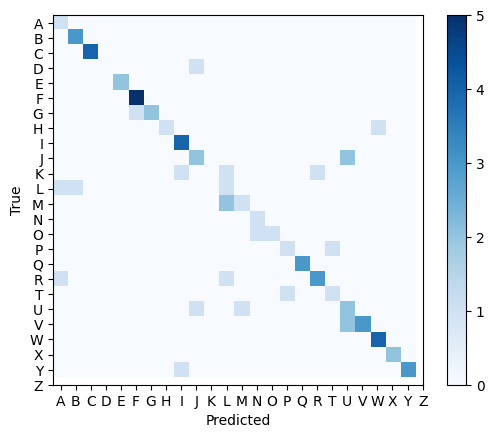

In [ ]:
# plot confusion matrix using matplotlib

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Plotting

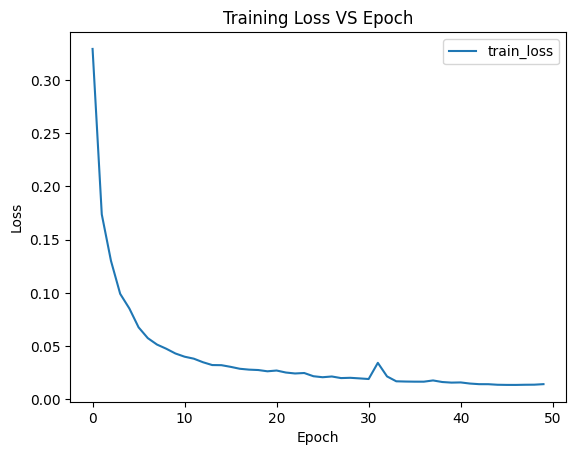

In [ ]:
# training and validation loss

plt.plot(H['train_loss'], label='train_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss VS Epoch')
plt.savefig('training_loss.png')
plt.show()

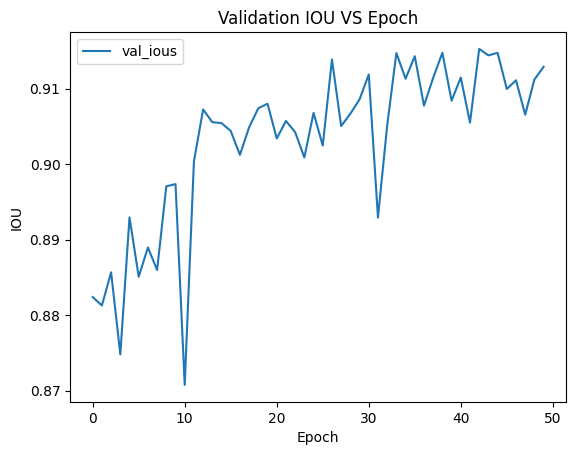

In [ ]:
# validation iou

plt.plot(H['val_ious'], label='val_ious')
plt.xlabel('Epoch')
plt.ylabel('IOU')
plt.legend()
plt.title('Validation IOU VS Epoch')
plt.savefig('validation_iou.png')
plt.show()

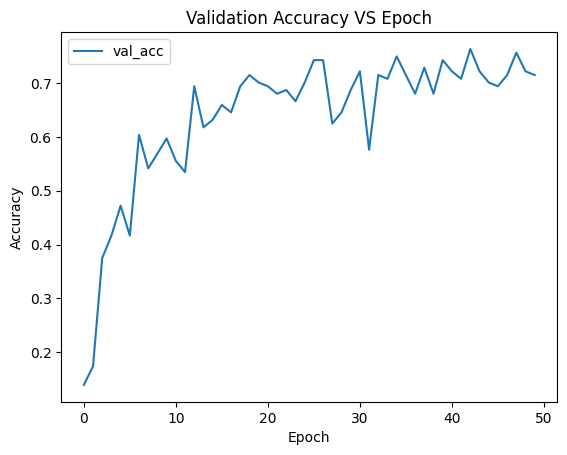

In [ ]:
# validation accuracy

plt.plot(H['val_acc'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy VS Epoch')
plt.savefig('validation_accuracy.png')
plt.show()

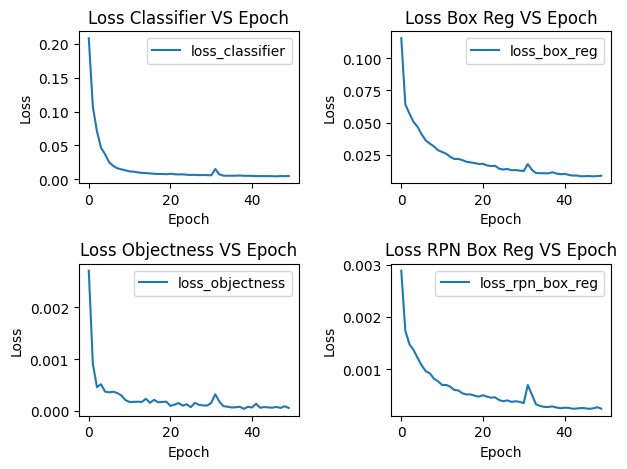

In [ ]:
# 4 loss subplots

plt.subplot(2, 2, 1)
plt.plot(H['loss_classifier'], label='loss_classifier')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Classifier VS Epoch')

plt.subplot(2, 2, 2)
plt.plot(H['loss_box_reg'], label='loss_box_reg')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Box Reg VS Epoch')

plt.subplot(2, 2, 3)
plt.plot(H['loss_objectness'], label='loss_objectness')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Objectness VS Epoch')

plt.subplot(2, 2, 4)
plt.plot(H['loss_rpn_box_reg'], label='loss_rpn_box_reg')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss RPN Box Reg VS Epoch')

plt.tight_layout()
plt.savefig('loss_subplots.png')
plt.show()


## Visualization

In [ ]:
torch.cuda.is_available()

True

In [8]:
# load best model
model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 27
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.load_state_dict(torch.load('models/trained_model.pth'))

c:\Users\tiany\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\tiany\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [9]:
# predict
model.to(device)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

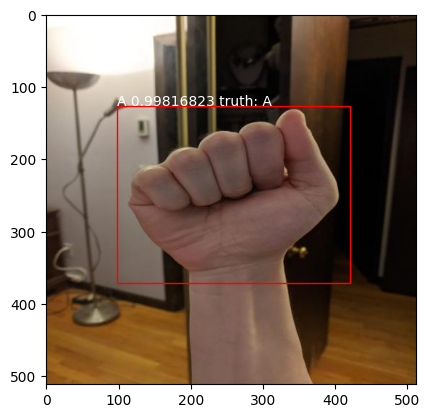

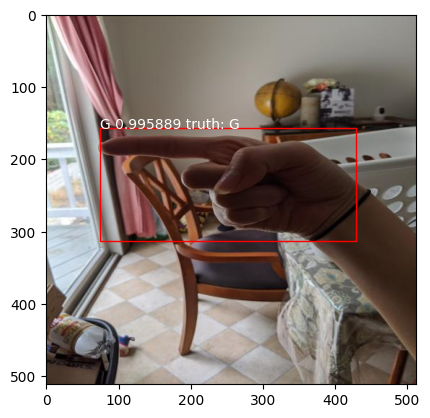

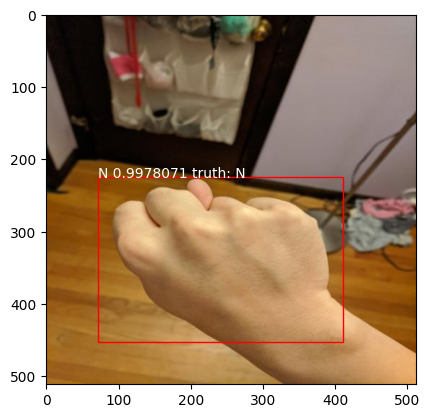

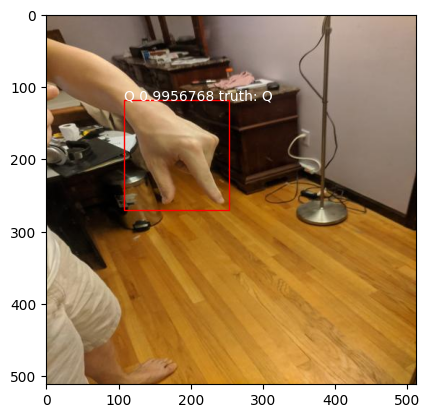

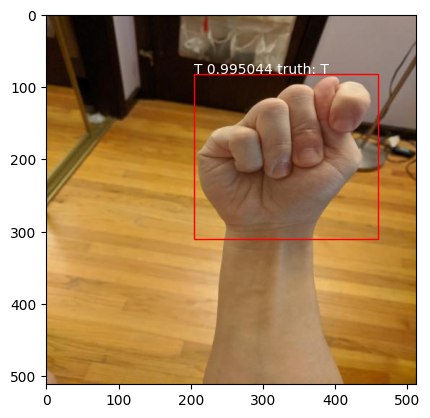

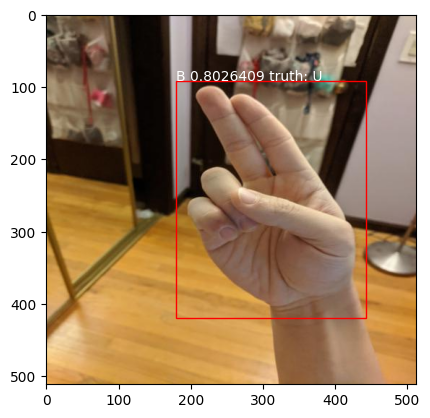

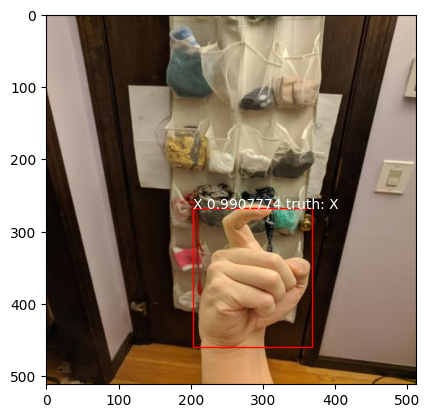

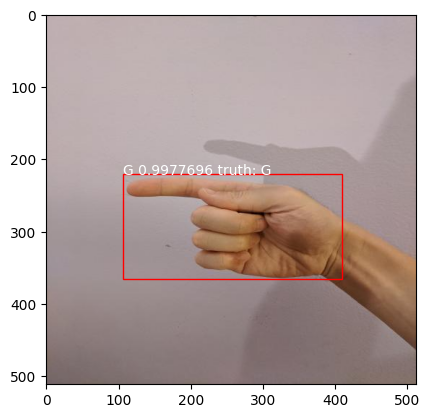

In [15]:
# visualize
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
imgs = []

for i in range(8):
    if i % 4 == 0:
        sample_img, sample_target = next(iter(test_dataloader))
    with torch.no_grad():
        output = model([sample_img[i%4].to(device)])
    fig, ax = plt.subplots(1)
    ax.imshow(sample_img[i%4].permute(1, 2, 0).cpu().numpy())

    # get bounding box
    box = output[0]['boxes'][0].cpu().numpy()

    # get class
    cls = output[0]['labels'][0].cpu().numpy()

    # get score
    score = output[0]['scores'][0].cpu().numpy()

    # draw bounding box
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    # add class name and score
    ax.text(box[0], box[1],  valToChar(cls)+ ' ' + str(score) + ' truth: ' + valToChar(sample_target[i%4]['labels'][0].cpu().numpy()), color='w')

plt.show()